# Imaging Processing Program

The following is an image processing technique used to track and determine characteristics of cell movement including velocity and angle.

## Setup the Project:

In [1]:
from __future__ import division, unicode_literals, print_function
import os.path
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc("figure", figsize=(10, 5))
mpl.rc('image', cmap='gray')

In [2]:
import numpy as np 
import pandas as pd
from pandas import DataFrame, Series

In [3]:
import pims
import trackpy as tp
import collections
import xlsxwriter

## Read data and convert to grayscale

#### Import the path for your AVI video in cell below inbetween the quotes:

In [4]:
#video_path = '/Users/ashty/Downloads/testcells.avi'
video_path = '/mnt/c/Users/kingf/Desktop/videoalgea/14-x2-2.avi'
#video_path = '/mnt/c/Users/kingf/Desktop/videoalgea/18-3xbfafter2.avi'
#video_path = '/mnt/c/Users/kingf/Desktop/videoalgea/18-3xbfbefore2.avi'


In [5]:
@pims.pipeline
def gray(image):
    return image[:, :, 1]

if os.path.exists(video_path):
    frames = gray(pims.Video(video_path))
    print('Video loaded successfully!')
else: 
    print('Video fild not found:', video_path)
    

Video loaded successfully!


In [6]:
#frames

## Show the first frame

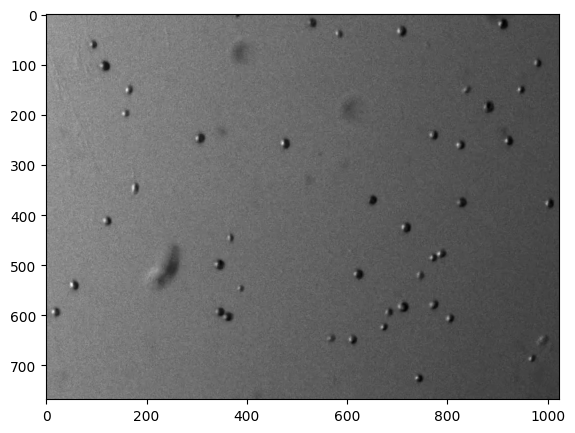

In [7]:

plt.imshow(frames[0])
#plt.gca().invert_yaxis()

## Locate cells

#### The second number in the parenthesis is an estimate of cell size in pixels. It needs to be an odd integer.

In [8]:
f = tp.locate(frames[0], 17, invert=True)

In [9]:
f.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,9.400134,294.589812,374.225425,4.946971,0.087178,8.527925,26836.0,-0.144410,0
1,5.816910,610.563891,394.541953,5.031307,0.232464,8.778747,31675.0,-0.576300,0
2,7.425573,689.559160,262.860754,5.028355,0.389042,7.524640,32595.0,-1.335894,0
3,12.319463,862.905369,373.723782,4.369433,0.233374,6.521355,34536.0,0.750164,0
4,7.486157,571.466224,452.983322,5.003210,0.266651,9.280389,31440.0,-0.503213,0


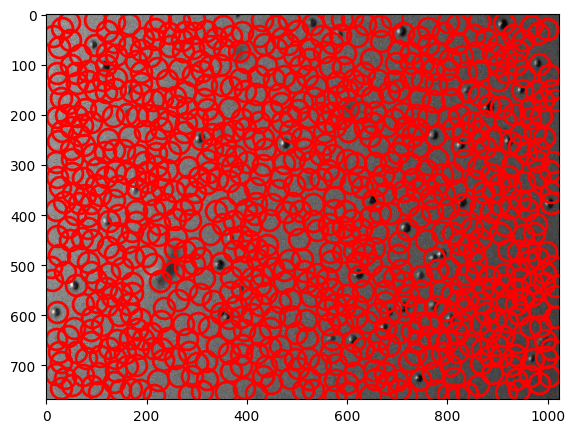

In [10]:
tp.annotate(f, frames[0]);

## Filter based on brightness

#### The plot of cell count versus mass

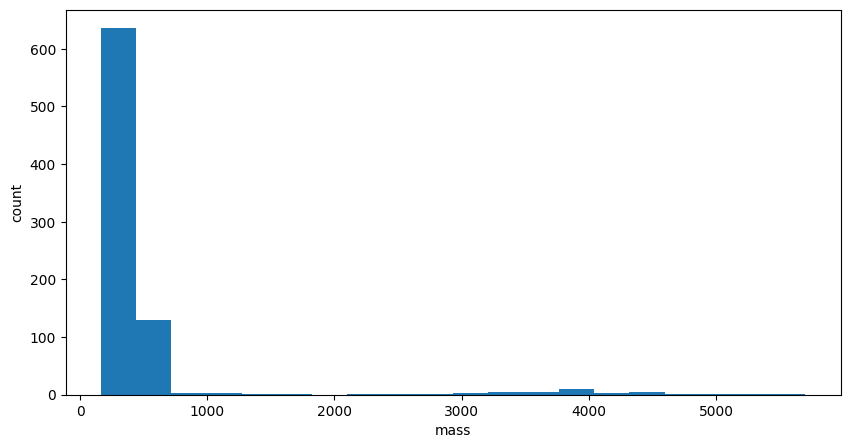

In [11]:
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=20)

ax.set(xlabel='mass', ylabel='count');

#### Now apply the minimum mass parameter based on the plot

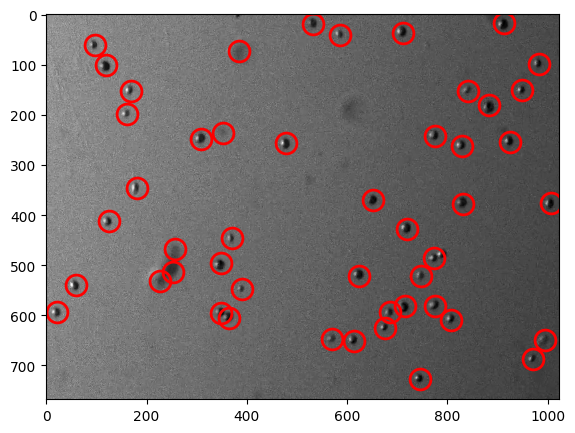

In [12]:
f = tp.locate(frames[0], 17, invert=True, minmass=1000)
tp.annotate(f, frames[0]);

## Check for Subpixel Accuracy in 

/home/fenix/.local/lib/python3.10/site-packages/trackpy/plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

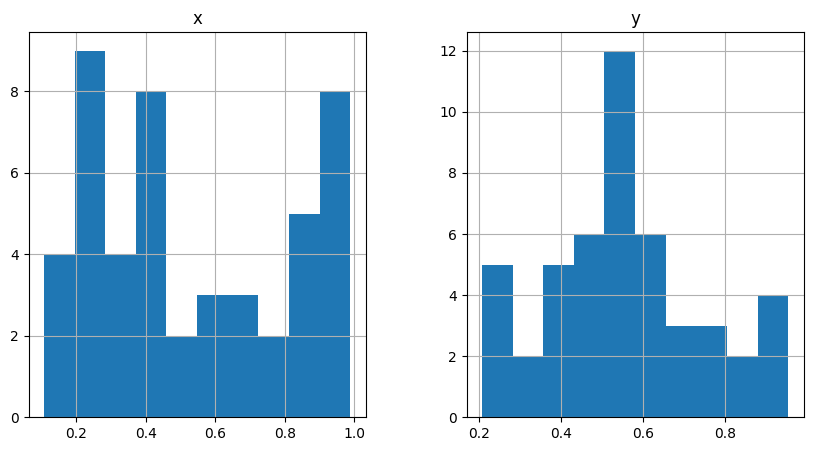

In [13]:
tp.subpx_bias(f)

/home/fenix/.local/lib/python3.10/site-packages/trackpy/plots.py:638: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  axlist = f[pos_columns].applymap(lambda x: x % 1).hist()


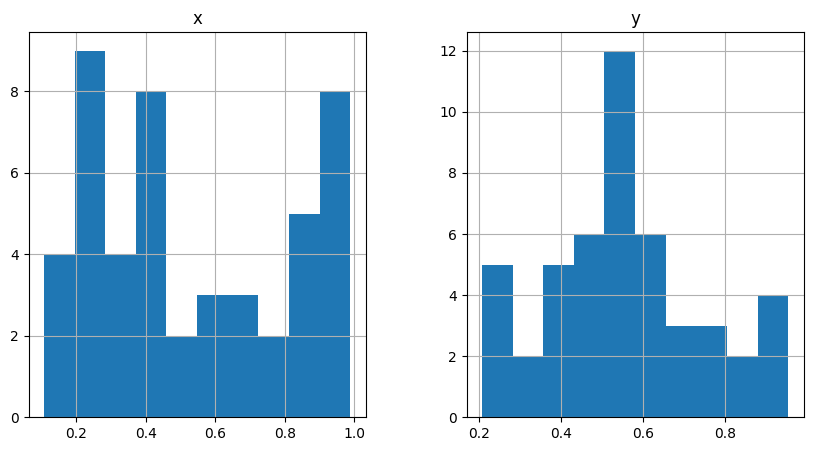

In [14]:
tp.subpx_bias(tp.locate(frames[0], 17, invert=True, minmass=1000));

## Collect data from set of frames into a table

#### Plug in the number of frames you would like to collect data from

#### Since our AVI files are 5 seconds in length with 25 frames/second we will have around a total of 150 frames. 

In [15]:
f = tp.batch(frames[:150], 17, minmass=1000, invert=True,processes=1);

Frame 148: 46 features


## Link located cells into particle trajectories

In [16]:
t = tp.link(f, 10, memory=3)

Frame 148: 92 trajectories present.


In [17]:
t.head()

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,particle
0,17.400392,912.518292,3969.749194,5.059225,0.249587,37.623200,44741.0,0.081451,0,0
69,376.576207,1005.871733,3666.506206,4.701138,0.287885,42.137983,43252.0,0.093629,0,1
68,370.266862,652.196719,4373.320715,5.186104,0.132722,36.118272,44673.0,0.081938,0,2
67,345.368460,180.386006,4688.853948,4.560284,0.395930,63.959439,32062.0,-0.757477,0,3
66,262.522927,828.951922,3719.680328,4.631797,0.337994,47.405231,41147.0,0.118723,0,4


### Display a walk through

#### Let us display the program locating one cell and assigning an ID number to the cell

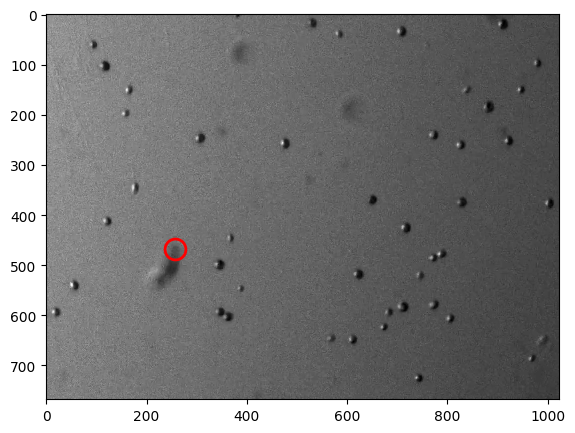

In [18]:
particle_id = 24;
p=t[t['particle']==particle_id]
q=p[p['frame']==0]
tp.annotate(q, frames[0]);

#### Now let us display the tracking locations for all the frames throughout the entirety of the video

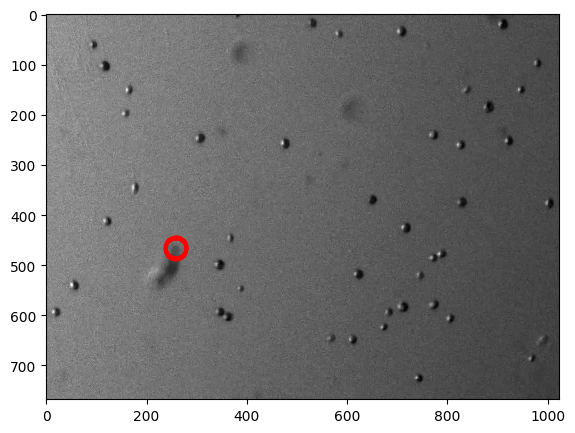

In [19]:
particle_id = 24;
p=t[t['particle']==particle_id]
tp.annotate(p, frames[0]);

## Filter Trajectories

#### Keep only the trajectories that last a certain number of frames (here we test 10 frames)

In [20]:
t1 = tp.filter_stubs(t, 5)

#### Compare the # of trajectories before and after filtering

In [21]:
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 406
After: 222


## Filter based on particles' appearance

#### Plot mass vs. size of particles

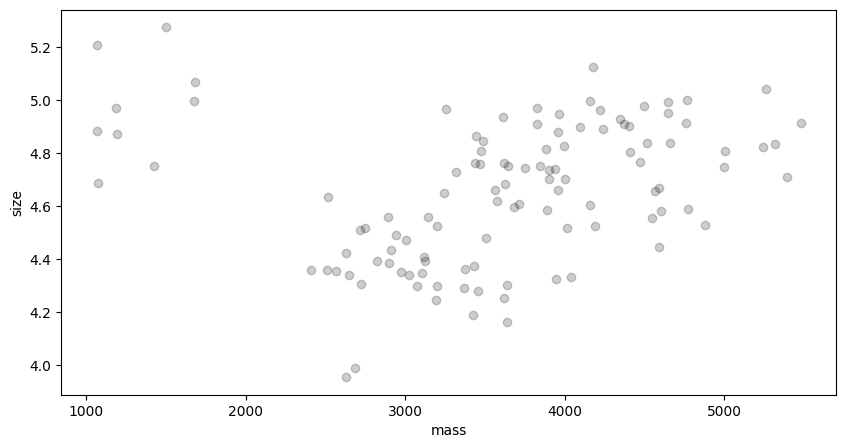

In [22]:
plt.figure()
tp.mass_size(t1.groupby('particle').mean());

#### Now apply the filter based on the mass, size, and eccentricity

In [23]:
t2 = t1[((t1['mass'] > 1000) & (t1['size'] < 5) & (t1['ecc'] < 3))]

## Plot the filtered trajectories

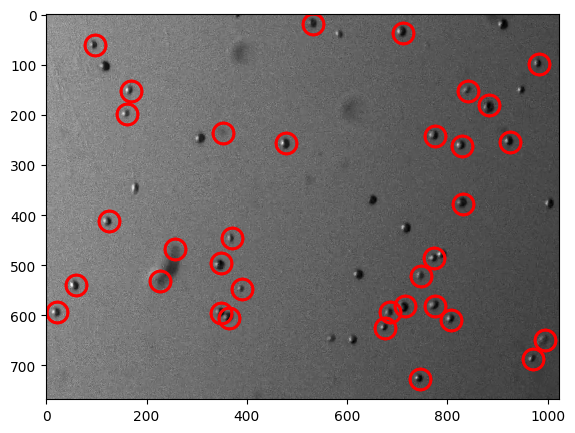

<Axes: >

In [24]:
plt.figure()
tp.annotate(t2[t2['frame'] == 0], frames[0])

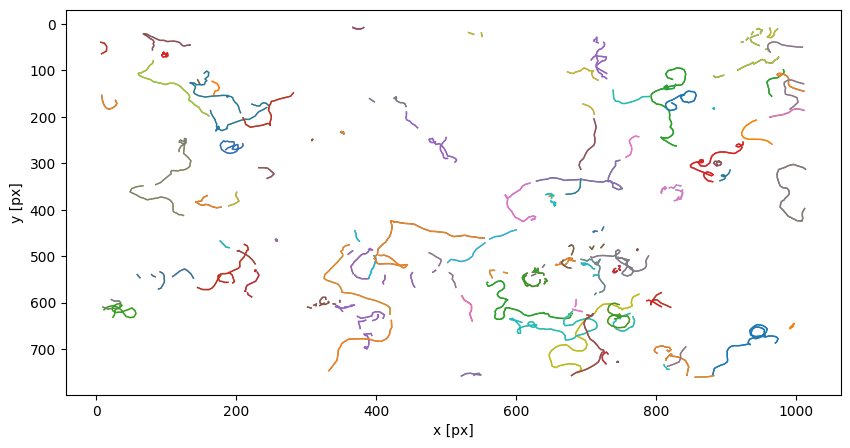

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [25]:
plt.figure()
tp.plot_traj(t2)

#### Save first set of data to an excel file. Title the excel file per video. 

In [26]:
excel_file = pd.ExcelWriter('Cell_Movement_Characteristics_13x2.xlsx', engine='xlsxwriter')
workbook=excel_file.book
worksheet=workbook.add_worksheet('Trajectory Data')
t2.to_excel(excel_file, sheet_name='Trajectory Data', index=False)

In [27]:
print(t2)

                y           x         mass      size       ecc     signal  \
frame                                                                       
0      262.522927  828.951922  3719.680328  4.631797  0.337994  47.405231   
0      254.552701  924.180081  3885.974870  4.694075  0.286688  40.883877   
0      255.498421  478.935475  4528.579118  4.813417  0.260056  49.160981   
0      242.880616  775.173919  3890.991297  4.633558  0.329260  45.398661   
0      235.558539  352.658893  1064.736547  4.780210  0.075801  13.293531   
...           ...         ...          ...       ...       ...        ...   
148    474.700517  211.935707  4879.253536  4.948436  0.259869  52.375698   
148    467.581195  258.928692  1317.428938  4.985929  0.169443  14.410245   
148    467.328049  177.389674  4492.393881  4.875623  0.270630  51.544338   
148    420.635512  626.626445  3667.684475  4.593798  0.345733  49.604497   
148    532.251912  744.683145  2573.060094  4.320307  0.299060  35.471372   

In [28]:
#excel_file = pd.ExcelWriter('Cell_Movement_Characteristics_11x2.xlsx', engine='xlsxwriter')
#excel_file = pd.ExcelWriter('Cell_Movement_Characteristics_9x3.xlsx', engine='xlsxwriter')
#excel_file = pd.ExcelWriter('Cell_Movement_CharacteristicsXXX.xlsx', engine='xlsxwriter')

## Find average cell position every third frame and convert unit pixels into micrometers

#### First plug in your conversion factor 'cf' based on the microscope magnification for your video in cell below. 
This is the ratio micrometer/pixel

In [29]:
cf = 1/1.149 # for video x2
#cf = 1/1.749 # for video x3

#### Note 'df' is the number of frames we are taking the average of

In [30]:
t3=t2.copy()

In [31]:
df = 3
t3['x_ave'] = ((t3['x'] + t3.groupby('particle')['x'].shift(1) + t3.groupby('particle')['x'].shift(2))/ df)*cf
t3['y_ave'] = ((t3['y'] + t3.groupby('particle')['y'].shift(1) + t3.groupby('particle')['y'].shift(2))/ df)*cf
#t4 = t3[(t3['frame']+1) % 3 == 0]
t5 = (t3[['frame', 'particle', 'x_ave', 'y_ave']])
print(t5)

       frame  particle       x_ave       y_ave
frame                                         
0          0         4         NaN         NaN
0          0         5         NaN         NaN
0          0         6         NaN         NaN
0          0         8         NaN         NaN
0          0         9         NaN         NaN
...      ...       ...         ...         ...
148      148       209  187.113073  416.274793
148      148       174  224.965811  406.208063
148      148       382  158.408833  412.899135
148      148       264  543.551153  366.414068
148      148       263  647.984450  462.768659

[5488 rows x 4 columns]


#### Save data to the excel file

In [32]:
t5.to_excel(excel_file, sheet_name='Average Position', index=False)

In [33]:
t5.to_excel("errorfind.xlsx", index=False)

## Find Velocity (micrometer/second) & Angle (degrees) & Save Data

#### Plug in your change in time for 'dt' 

#### Here we have 25.33 frames/second and we took the average position of three frames therefore dt = 1/50.66 * 3 = 0.118second

In [34]:
t6 = t5.copy()

In [35]:
dt= (1/50.66)*3
t6['dx']=t6['x_ave'] - t6.groupby('particle')['x_ave'].shift(1)
t6['dy']=t6['y_ave'] - t6.groupby('particle')['y_ave'].shift(1)
t6['velocity'] = ((t6['dx'] ** 2 + t6['dy'] ** 2) ** 0.5) / dt

t6['movement_angle'] = np.arctan2(-t6['dy'], t6['dx']) * (180/np.pi)

In [36]:
v = (t6[t6['frame'] >=5])

print(v)

       frame  particle       x_ave       y_ave        dx        dy   velocity  \
frame                                                                           
6          6         8  666.485857  214.219723 -3.852934  2.476760  77.346545   
6          6         4  716.096294  225.959211 -2.914207 -1.700387  56.975719   
6          6        54  799.915838  228.512151 -2.819408  2.580227  64.538523   
6          6        58  305.530461  203.697711       NaN       NaN        NaN   
6          6       102         NaN         NaN       NaN       NaN        NaN   
...      ...       ...         ...         ...       ...       ...        ...   
148      148       209  187.113073  416.274793 -1.581215 -3.398468  63.296455   
148      148       174  224.965811  406.208063  0.141233 -0.094733   2.871785   
148      148       382  158.408833  412.899135 -3.692348 -4.157223  93.893416   
148      148       264  543.551153  366.414068  0.216281  0.323734   6.574564   
148      148       263  647.

In [37]:
v.to_excel(excel_file, sheet_name='Velocity and Angle', index=False)

## Plot Velocities of Cells

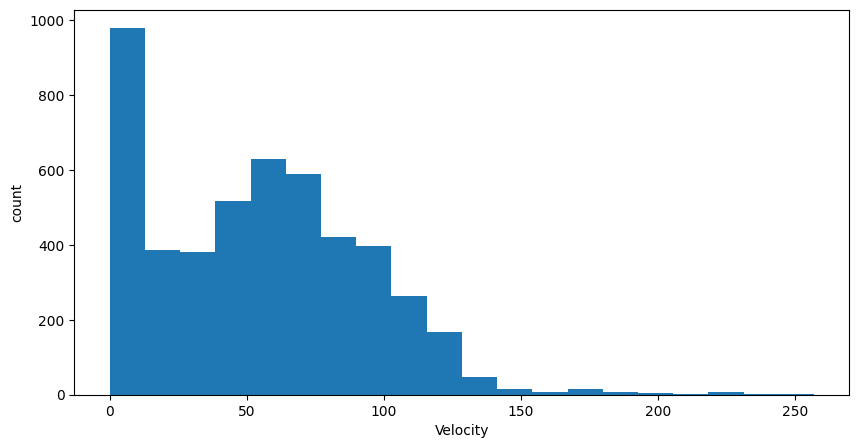

In [38]:
fig, ax = plt.subplots()
ax.hist(v['velocity'], bins =20)
ax.set(xlabel='Velocity', ylabel='count');

## Filter non-moving particles (zero velocities)

In [39]:
t7 = v.copy()
filtered_v = t7[t7['velocity']> 15]
print(filtered_v)

       frame  particle       x_ave       y_ave        dx        dy   velocity  \
frame                                                                           
6          6         8  666.485857  214.219723 -3.852934  2.476760  77.346545   
6          6         4  716.096294  225.959211 -2.914207 -1.700387  56.975719   
6          6        54  799.915838  228.512151 -2.819408  2.580227  64.538523   
6          6        59  133.097285  165.142711 -3.592330 -3.939513  90.030794   
6          6        61  727.508784  137.087967 -1.285199  2.203733  43.079791   
...      ...       ...         ...         ...       ...       ...        ...   
148      148        97  589.630570  542.832953  2.746178 -3.744959  78.420733   
148      148       327  622.640668  470.860863  2.037903  0.342528  34.896101   
148      148       376  586.272218  455.747550  3.431344  2.313879  69.887457   
148      148       209  187.113073  416.274793 -1.581215 -3.398468  63.296455   
148      148       382  158.

## Plot Filtered Velocities

Text(0.5, 1.0, 'Cell Velocities')

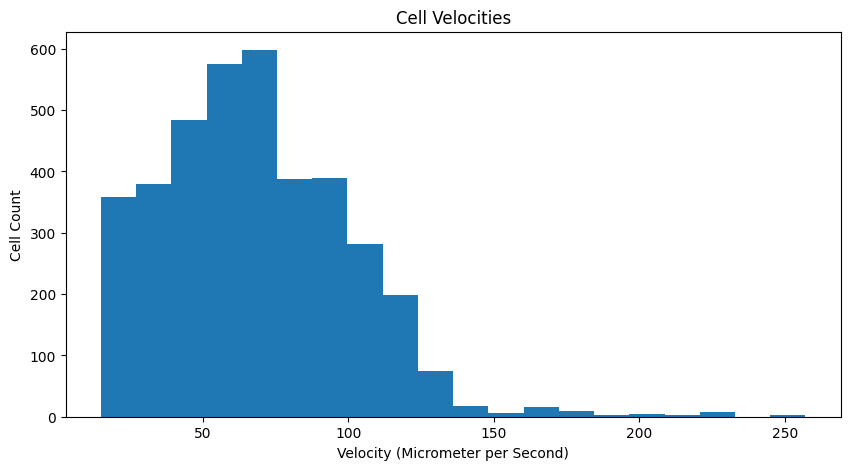

In [40]:
fig, ax = plt.subplots()
ax.hist(filtered_v['velocity'], bins =20)
ax.set(xlabel='Velocity (Micrometer per Second)', ylabel='Cell Count');
ax.set_title('Cell Velocities')

In [41]:
filtered_v.to_excel(excel_file, sheet_name='Filtered Velocity and Angle', index=False)

In [42]:
print(filtered_v)

       frame  particle       x_ave       y_ave        dx        dy   velocity  \
frame                                                                           
6          6         8  666.485857  214.219723 -3.852934  2.476760  77.346545   
6          6         4  716.096294  225.959211 -2.914207 -1.700387  56.975719   
6          6        54  799.915838  228.512151 -2.819408  2.580227  64.538523   
6          6        59  133.097285  165.142711 -3.592330 -3.939513  90.030794   
6          6        61  727.508784  137.087967 -1.285199  2.203733  43.079791   
...      ...       ...         ...         ...       ...       ...        ...   
148      148        97  589.630570  542.832953  2.746178 -3.744959  78.420733   
148      148       327  622.640668  470.860863  2.037903  0.342528  34.896101   
148      148       376  586.272218  455.747550  3.431344  2.313879  69.887457   
148      148       209  187.113073  416.274793 -1.581215 -3.398468  63.296455   
148      148       382  158.

## Plot Directions of Cell Velocities

Text(0.5, 1.0, 'Directions of Cell Velocities')

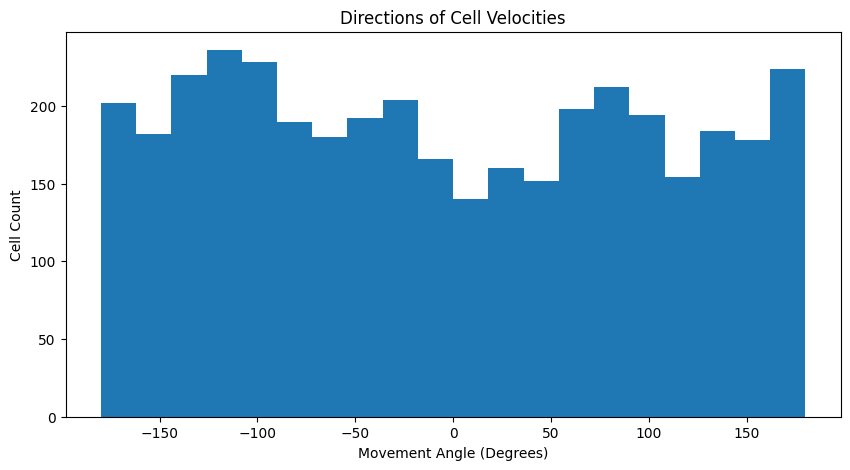

In [43]:
fig, ax = plt.subplots()
ax.hist(filtered_v['movement_angle'], bins =20)
ax.set(xlabel='Movement Angle (Degrees)', ylabel='Cell Count');
ax.set_title('Directions of Cell Velocities')

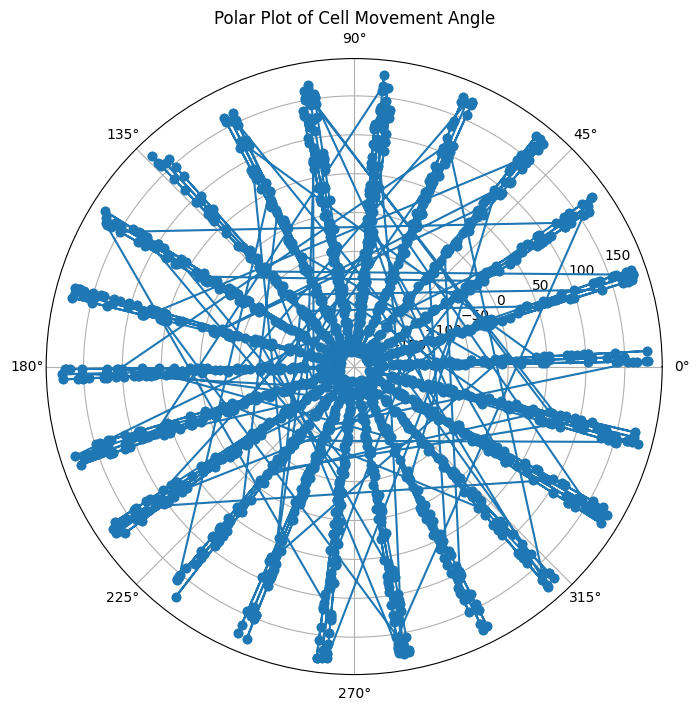

In [44]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1, polar=True)

ax.plot(filtered_v['movement_angle'], marker='o')
ax.set_title('Polar Plot of Cell Movement Angle')
plt.show()

In [45]:
excel_file.close()